# RoboCOP tutorial

In this tutorial, we will run RoboCOP on segments of the yeast genome. We will first run RoboCOP with expectation maximization (EM) on a few segments of the yeast genome to learn the weights of the DNA binding factors (DBFs). Once we have learned the DBF weights, we will run RoboCOP again on more segments of the genome without EM. Due to memory contraints we limit each segment to be less than 8000 bases. We also recommend that the minimum segment size be 3000 bases so that the Hidden Markov Model (HMM) can learn from a sufficiently long sequence of observations. 

In our [RoboCOP paper](https://doi.org/10.1093/nar/gkab553), we trained the model (using EM) on chrIV of the genome. We split chrIV into segments of length 5000 bases with an overlap of 1000 bases between two consecutive segments. After training, we ran RoboCOP without EM on the entire genome, split into segments of length 5000 with overlapping 1000 bases.

Here we run RoboCOP on a MNase-seq BAM file containing only chromosomes chrI and chrII of the yeast genome. The genome version used is sacCer3. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# include path to RoboCOP directory
import sys
sys.path.insert(0, '../pkg/')
from run_robocop import run_robocop_with_em, run_robocop_without_em, plot_robocop_output

A config file is given as an input to train RoboCOP. In this tutorial we will use the provided config file ``config_example.ini``.

The config file contains the following information:

**fragRangeLong**: The range of fragments from paired end MNase-seq (or ATAC-seq) to be used as nucleosomal fragments (nucFrags). In this analysis, we use the range of fragments between 127 and 187. Please see [Fig 1](https://academic.oup.com/view-large/figure/287581809/gkab553fig1.jpg) in the [paper](https://doi.org/10.1093/nar/gkab553) for more details.

**fragRangeShort**: The range of fragments from paired-end MNase-seq (or ATAC-seq) to be used as subnucleosomal fragments (shortFrags) to predict transcription factor binding sites. In this analysis, we use fragments of length less than or equal to 80. Please see [Fig 1](https://academic.oup.com/view-large/figure/287581809/gkab553fig1.jpg) in the [paper](https://doi.org/10.1093/nar/gkab553) for more details.

**cshared**: Path to the RoboCOP shared object (``librobocop.so``) containing HMM functions. Before running RoboCOP for the first time, please generate this file by running ``bash gccCompile`` in the ``pkg`` directory. Then add the file path to the generated file, ``librobocop.so``, in the config file.

**pwmFile**: Set of position weight matrices (PWMs) for transcription factors (TFs). The motifs are required to be in [MEME format](https://meme-suite.org/meme/doc/examples/sample-dna-motif.meme).

**nucleosomeFile**: Set of annotated nucleosome dyads in [BED format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1). The nucFrags signal of 147 bases centered on the annotated dyads are used to fit a negative binomial distribution for prediction nucleosome positions in the genome. These annotated sites are also used to compute a dinucleotide PWM for nucleosomal DNA. In this tutorial, we will use the annotated +1 and -1 nucleosome dyads from [Chereji et al., 2018](https://doi.org/10.1186/s13059-018-1398-0).

**tfFile**: Set of annotated transcription factor binding sites in [BED format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1). The shortFrags signal within these annotated sites are used to fit a negative binomial distribution for predicting TF binding sites. In this tutorial, we will be using the annotated binding sites of Abf1 and Reb1 from [MacIsaac et al., 2006](https://doi.org/10.1186/1471-2105-7-113).

**nucFile**: Nucleotide sequence of the genome. Here we will use the sacCer3 genome.

**bamFile**: MNase-seq (or ATAC-seq) paired-end reads in [BAM file format](https://samtools.github.io/hts-specs/SAMv1.pdf). In this tutorial, we will use a BAM file containing chromosomes chrI and chrII.

**chrSizesFile**: File with chromosome sizes.

**gtfFile**: Gene body and transcript information in [GTF format](https://genome.ucsc.edu/FAQ/FAQformat.html#format4). This input is optional. It is required only during plotting. When included, the plots show the gene information. 

**tech**: Can be MNase or ATAC depending on the experimental protocol used to generate the input BAM file. Here we set it as MNase because the input BAM file is MNase-seq.

In [3]:
configfile = './config_example.ini'


We will use separate set of segments for running RoboCOP with EM (training) and without EM. We generally train on fewer segments to learn the DBF weights. After learning the weights we performing posterior decoding by running RoboCOP without EM on all our segments of interest. The coordinate files for the two RoboCOP runs in tutorial are as follows.

In [4]:
coord_file_train = './coord_train.tsv'
coord_file_all = './coord_all.tsv'
coord_file_abf1_train = './coord_all_abf1.tsv'
coord_file_fiber_train = './coord_all_fiber.tsv'

In [5]:
!cat "$coord_file_train"

chr	start	end
chrI	24001	29000
chrI	28001	33000
chrI	60001	65000
chrI	64001	69000
chrI	68001	73000


In [6]:
!cat "$coord_file_all"

chr	start	end
chrI	24001	29000
chrI	28001	33000
chrI	60001	65000
chrI	64001	69000
chrI	68001	73000
chrII	72001	77000
chrII	76001	81000
chrII	180001	185000
chrII	184001	189000
chrII	380001	385000


In [7]:
# Output directories for the RoboCOP runs
outdir_train = './robocop_train/'
outdir_all = './robocop_all/'
outdir_all_abf1 = './robocop_all_abf1/'
outdir_all_fiber = './robocop_all_fiber/'
outdir_all_subset = './robocop_all_subset/'

### Run RoboCOP with EM

We first need to run RoboCOP with EM on a few set of genome segments to learn the DBF weights. Note that the same coordinate file can be used to run RoboCOP with and without EM. If the number of segments in the coordinate file is more than 500 then for the EM run, RoboCOP randomly chooses 500 segments to train the model on. In order to run RoboCOP with EM, we need to provide a coordinate file, config file and an output directory.

In [8]:
run_robocop_with_em(coord_file_fiber_train, configfile, outdir_train)

RoboCOP: model training ...
Coordinates: ./coord_all_fiber.tsv
Config file: ./config_example.ini
Output dir: ./robocop_train/
Number of motifs: 153
nuc transition is 0.0013572753679111484
unknown TF transition is 0.050107733238388324
bg transition is 0.9332338342081699
nuc transition is 0.0013572753679111484
unknown TF transition is 0.050107733238388324
bg transition is 0.9332338342081699
nuc transition is 0.0013572753679111484
unknown TF transition is 0.050107733238388324
bg transition is 0.9332338342081699
nuc transition is 0.0013572753679111484
unknown TF transition is 0.050107733238388324
bg transition is 0.9332338342081699
nuc transition is 0.0013572753679111484
unknown TF transition is 0.050107733238388324
bg transition is 0.9332338342081699
Writing MNase params
nuc transition is 0.003453194555146111
unknown TF transition is 0.05078625228184288
bg transition is 0.9354435511211521
nuc transition is 0.003453194555146111
unknown TF transition is 0.05078625228184288
bg transition is 

/usr/project/xtmp/nd141/programs/roboNhat_w_new_changes/analysis/../pkg/robocop/robocop.py:997: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(save_dir, f"emission_layer_{layer}.png"), dpi=150)


nuc transition is 0.007252910425497971
unknown TF transition is 0.044187343705602115
bg transition is 0.9330110634832818
nuc transition is 0.007252910425497971
unknown TF transition is 0.044187343705602115
bg transition is 0.9330110634832818
nuc transition is 0.007252910425497971
unknown TF transition is 0.044187343705602115
bg transition is 0.9330110634832818
nuc transition is 0.007252910425497971
unknown TF transition is 0.044187343705602115
bg transition is 0.9330110634832818
nuc transition is 0.007252910425497971
unknown TF transition is 0.044187343705602115
bg transition is 0.9330110634832818
nuc transition is 0.007527747794096654
unknown TF transition is 0.04314239629228379
bg transition is 0.9332730248193951
nuc transition is 0.007527747794096654
unknown TF transition is 0.04314239629228379
bg transition is 0.9332730248193951
nuc transition is 0.007527747794096654
unknown TF transition is 0.04314239629228379
bg transition is 0.9332730248193951
nuc transition is 0.007527747794096

rm: cannot remove './robocop_train/tmpDir': Directory not empty


### Run RoboCOP without EM

##### Here we run RoboCOP without EM on all segments.

In [11]:
run_robocop_without_em(coord_file_fiber_train, outdir_train, outdir_all_fiber)

RoboCOP: model fitting ...
Coordinates: ./coord_all_fiber.tsv
Config file: ./robocop_all_fiber/config.ini
Train dir: ./robocop_train/
Output dir: ./robocop_all_fiber/
Config sections: ['main'] ./robocop_all_fiber/config.ini
Segment: 0
nuc transition is 0.008011118020050051
unknown TF transition is 0.04116929827149047
bg transition is 0.9338881081429472
Segment: 1
nuc transition is 0.008011118020050051
unknown TF transition is 0.04116929827149047
bg transition is 0.9338881081429472
Segment: 2
nuc transition is 0.008011118020050051
unknown TF transition is 0.04116929827149047
bg transition is 0.9338881081429472
Segment: 3
nuc transition is 0.008011118020050051
unknown TF transition is 0.04116929827149047
bg transition is 0.9338881081429472
Segment: 4
nuc transition is 0.008011118020050051
unknown TF transition is 0.04116929827149047
bg transition is 0.9338881081429472


##### Run RoboCOP without EM on a subset of segments for parallelization

We can also run RoboCOP without EM on a subset of segments. 

For example, here we split the set of coordinates into a ``total`` of 3 groups and run RoboCOP without EM on every third segment starting at ``idx = 2``. In our file, ``coord_file_all`` we have 10 segments with indices ``[0 .. 9]``. So, with the segmenting approach, we will perform posterior decoding on segments with indices ``[2, 5, 8]``.

We can use this segmenting approach to run RoboCOP without EM in parallel on HPC cluster. Therefore, in this case, in order to run RoboCOP on all segments, we would need to run RoboCOP without EM for ``idx`` values 0, 1, and 2 separately.

In [12]:
run_robocop_without_em(coord_file_all, outdir_train, outdir_all_subset, idx = 0, total = 3)
run_robocop_without_em(coord_file_all, outdir_train, outdir_all_subset, idx = 1, total = 3)
run_robocop_without_em(coord_file_all, outdir_train, outdir_all_subset, idx = 2, total = 3)

RoboCOP: model fitting ...
Coordinates: ./coord_all.tsv
Config file: ./robocop_all_subset/config.ini
Train dir: ./robocop_train/
Output dir: ./robocop_all_subset/
RoboCOP: model fitting ...
Coordinates: ./coord_all.tsv
Config file: ./robocop_all_subset/config.ini
Train dir: ./robocop_train/
Output dir: ./robocop_all_subset/
RoboCOP: model fitting ...
Coordinates: ./coord_all.tsv
Config file: ./robocop_all_subset/config.ini
Train dir: ./robocop_train/
Output dir: ./robocop_all_subset/


### Plot output

The output can be plotted using the plot_robocop_output() function. You need to provide the RoboCOP no EM directory name, chromosome, start and stop. Note that the genome segment needs to lie within the set of coordinates that RoboCOP without EM was run on.

Here the output is saved in the provided RoboCOP directory.

Output saved: ./robocop_all_fiber/figures/robocop_output_chrI_60500_64500.png


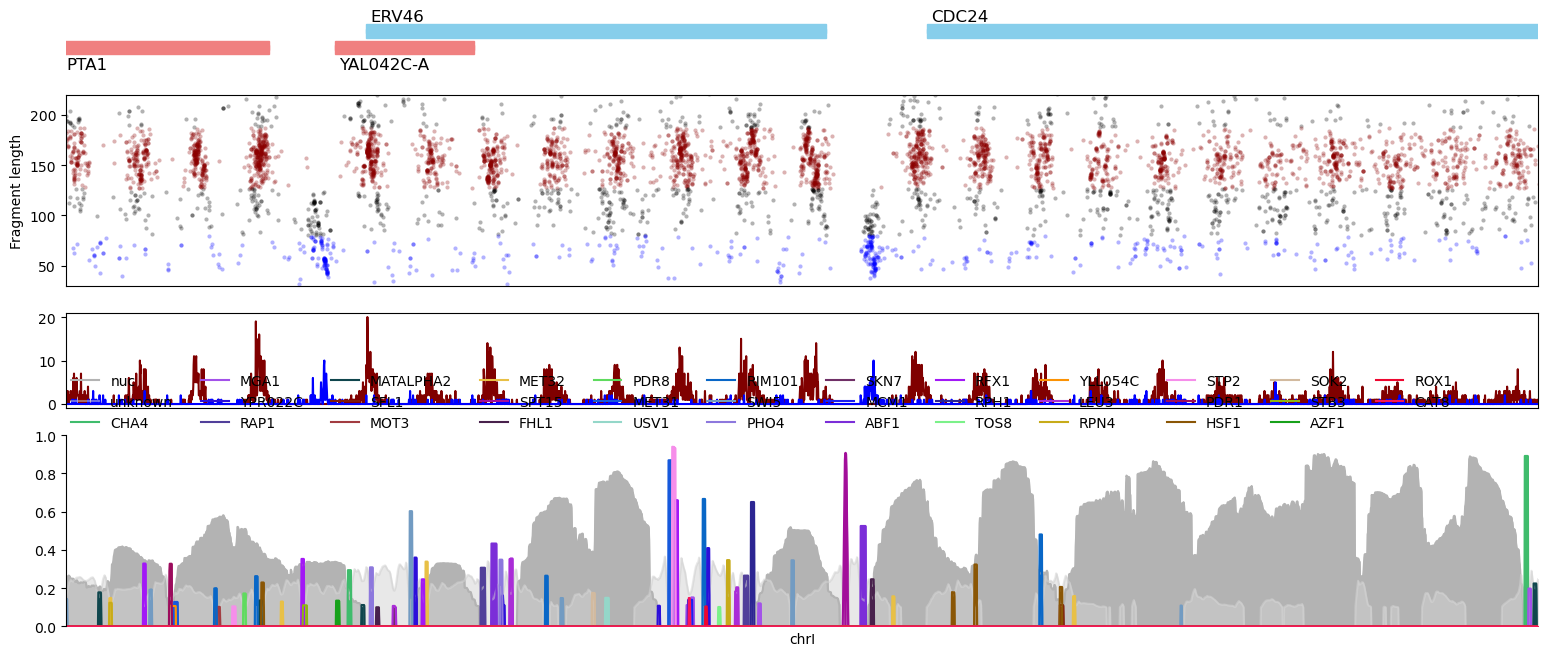

In [8]:
# outdir_all is run of RoboCOP without EM on all segments without splitting
plot_robocop_output(outdir_all_fiber, "chrI", 60500, 64500)

AttributeError: 'Legend' object has no attribute 'legendHandles'

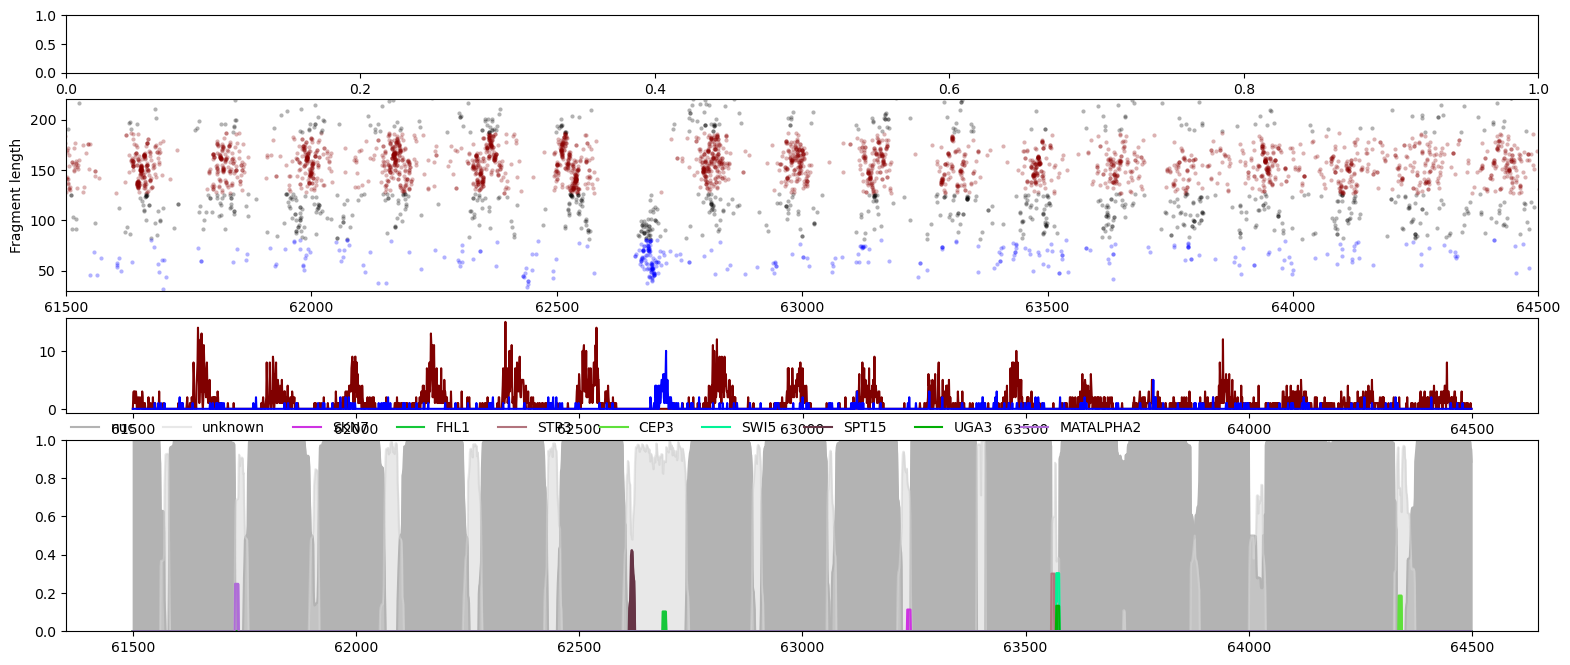

In [13]:
# outdir_all is run of RoboCOP without EM on all segments without splitting
plot_robocop_output(outdir_all_abf1, "chrI", 61500, 64500)

RoboCOP output can be plotted using the same function for both segmented and non-segmented RoboCOP runs.

In [10]:
# outdir_all_subset is run of RoboCOP without EM by splitting up the number of segments into groups
# to run in parallel
plot_robocop_output(outdir_all_subset, "chrII", 381000, 384000)

NoSectionError: No section: 'main'

Alternatively, by setting ``save=False``, you can display the output in the notebook without saving it in the RoboCOP directory.

AttributeError: 'Legend' object has no attribute 'legendHandles'

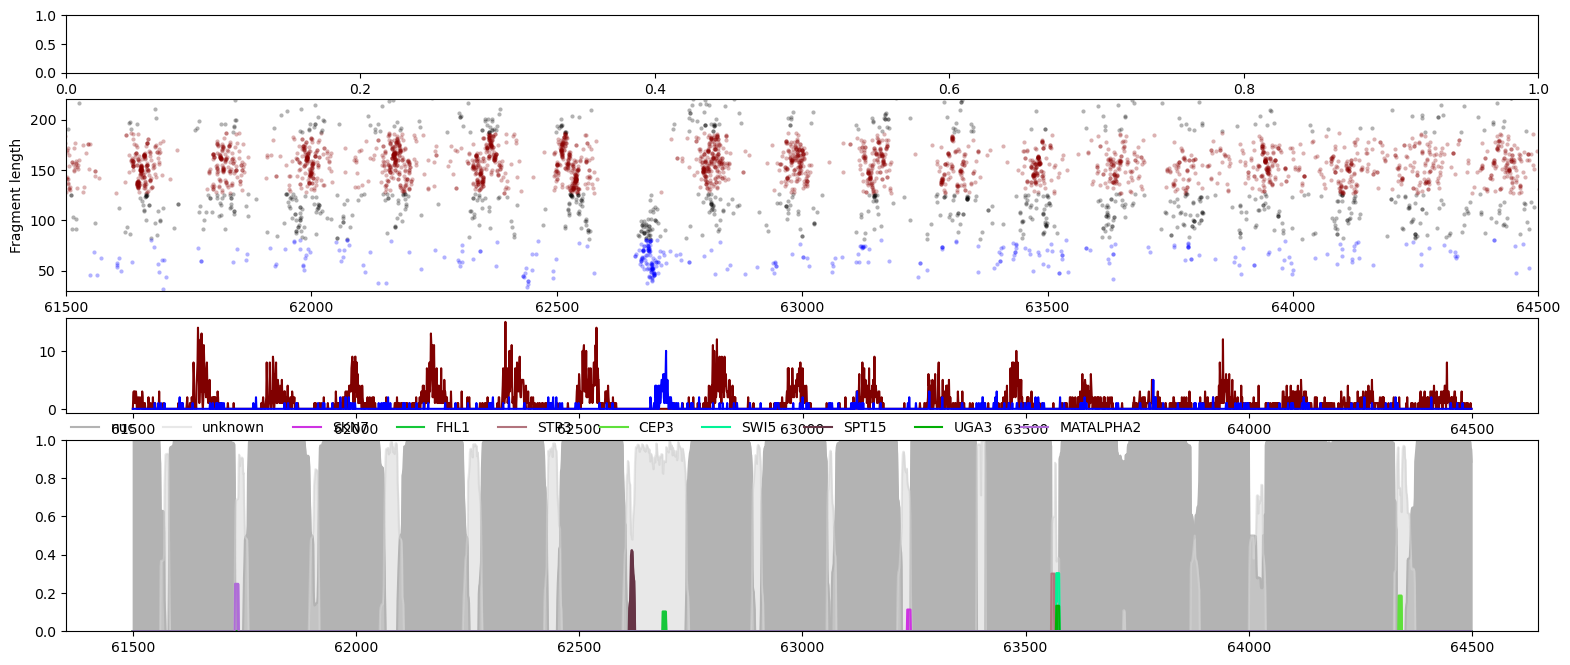

In [11]:
plot_robocop_output(outdir_all, "chrI", 61500, 64500, save = False)

In [8]:
print('bob')


bob
